# Comparing maps

Before we can construct NERC regions without SPP (as the [SPP will now be only an RTO](https://www.spp.org/newsroom/press-releases/southwest-power-pool-to-dissolve-regional-entity-focus-on-regional-transmission-organization-functions/) and is not present in the [2018 eGrid](https://www.epa.gov/energy/emissions-generation-resource-integrated-database-egrid)), we need a base map of the NERC regions. This is a bit tricky, as the border between regions is not always clear (especially around Missouri and Arkansas), and there is not a single authoritative source - or, at least, not one that I can find.

Here are our candidates:

1. A map from [EIA](https://www.eia.gov/maps/layer_info-m.php), also available from [eGrid](https://www.epa.gov/energy/emissions-generation-resource-integrated-database-egrid-questions-and-answers#egrid6).
2. A map from ESRI/DHS on their so-called [Homeland Infrastructure Foundation-Level Data](https://hifld-geoplatform.opendata.arcgis.com/datasets/6b2af23c67f04f4cb01d88c61aaf558a_0/data?geometry=137.589%2C10.313%2C30.714%2C58.170).
3. A map I traced from an NERC raster image which is now only available on [Wikipedia](https://en.wikipedia.org/wiki/North_American_Electric_Reliability_Corporation#/media/File:NERC-map-en.svg), constructed for the [ecoinvent database](https://www.ecoinvent.org/) and available at https://geography.ecoinvent.org/.

<img src="img/electricity-maps.png">

There are obviously significant differences between these three sources.

One way to choose between them is to compare these boundaries with the labels given in eGrid. Now, this is not perfect - eGrid is dirty data. For example, sometimes these use the county centroid instead of the actual location of the plants. But let's see what the numbers are like anyway.

In [1]:
%matplotlib inline

In [74]:
import matplotlib.pyplot as plt
from IPython.display import display
import geopandas as gp
import pandas as pd

Load the possible data sources, and normalize names

In [3]:
ecoinvent = gp.read_file("data/ecoinvent/electricity.gpkg")

mapping = {
    "US-ASCC": "ASCC",
    "US-FRCC": "FRCC",
    "US-HICC": "HICC",
    "MRO": "MRO",
    "NPCC": "NPCC",
    "US-RFC": "RFC",
    "US-SERC": "SERC",
    "US-SPP": "SPP",
    "US-TRE": "TRE",
    "WECC": "WECC",
}

ecoinvent = ecoinvent[ecoinvent['shortname'].isin(mapping)]
ecoinvent['NERC'] = ecoinvent['shortname'].transform(lambda s: mapping[s])
# Drop all columns except the name and shape
ecoinvent = ecoinvent[['NERC', 'geometry']]

In [46]:
hilfd = gp.read_file("data/HILFD/NERC_Regions_Subregions.shp")

mapping = {
    "FLORIDA RELIABILITY COORDINATING COUNCIL (FRCC)": "FRCC",
    "MIDWEST RELIABILITY ORGANIZATION (MRO)": "MRO",
    "NORTHEAST POWER COORDINATING COUNCIL (NPCC)": "NPCC",
    "RELIABILITYFIRST CORPORATION (RFC)": "RFC",
    "SERC RELIABILITY CORPORATION (SERC)": "SERC",
    "SOUTHWEST POWER POOL, RE (SPP)": "SPP",
    "TEXAS RELIABILITY ENTITY (TRE)": "TRE",
    "WESTERN ELECTRICITY COORDINATING COUNCIL (WECC)": "WECC",
}
hilfd['NERC'] = hilfd['NAME'].transform(lambda s: mapping[s])
# Drop all columns except the name and shape
hilfd = hilfd[['NERC', 'geometry']]
# Change from a projected CRS to lat/lon
hilfd = hilfd.to_crs(epsg=4326)

In [5]:
eia = gp.read_file("data/EIA/NercRegions_201907.shp")
# Drop all columns except the name and shape
eia = eia[['NERC', 'geometry']]

In [6]:
egrid_csv = pd.read_csv("data/egrid/egrid2018_data_v2.csv", skiprows=[1])

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (32,50,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Filter some of the eGrid data to remove invalid or unusable rows.

In [48]:
# Only use values which have GIS coordinates
egrid_csv = egrid_csv[egrid_csv['Plant latitude'] < 90]

# SPP no longer exists - plants with that label are not useful
print("Removing {} plants labeled SPP".format(sum(egrid_csv['NERC region acronym'] == 'SPP')))
egrid_csv = egrid_csv[egrid_csv['NERC region acronym'] != 'SPP']

Removing 0 plants labeled SPP


In [49]:
egrid = gp.GeoDataFrame(
    egrid_csv, 
    geometry=gp.points_from_xy(egrid_csv['Plant longitude'], egrid_csv['Plant latitude']),
    crs = {'init' :'epsg:4326'}
).rename(columns={'NERC region acronym': 'NERC'})

These CRSes are 4326, but as they are formatted slightly differently, we still get complaints. Let's avoid these complaints.

In [57]:
ecoinvent.crs = egrid.crs
hilfd.crs = egrid.crs
eia.crs = egrid.crs

Do a spatial join, using the `intersects` GIS operator to map ecoinvent NERC region labels to the eGrid plants. We then do the same thing with EIA and HILFD.

In [51]:
egrid = gp.sjoin(egrid, ecoinvent, how='inner', op='intersects', lsuffix='egrid', rsuffix='ecoinvent')

In [52]:
len(egrid)

10740

In [53]:
egrid = gp.sjoin(egrid, eia, how='inner', op='intersects', lsuffix='egrid', rsuffix='eia')
egrid = egrid.rename(columns={"NERC": "NERC_eia"})

In [54]:
len(egrid)

10547

In [55]:
egrid = gp.sjoin(egrid, hilfd, how='inner', op='intersects', lsuffix='egrid', rsuffix='hilfd')
egrid = egrid.rename(columns={"NERC": "NERC_hilfd"})

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [56]:
len(egrid)

10545

eGrid also has some incorrect NERC region labels. However, this is tricky to fix, and if the problem is in eGrid, it will give the same score to all three candidate maps, so we can ignore this issue for now.

Let's see how many plants there are where all three input maps agree on the NERC region, but eGrid has a different label. These should be (mostly) SPP plants, as eGrid doesn't have them anymore.

In [58]:
mask = (
    (egrid['NERC_ecoinvent'] == egrid['NERC_hilfd']) * 
    (egrid['NERC_ecoinvent'] == egrid['NERC_eia']) * 
    (egrid['NERC_ecoinvent'] != egrid['NERC_egrid'])
)
mask.sum()

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


482

In [70]:
egrid_cleaned = egrid[~mask]

Now, we can see the number of plants where each input map disagrees with eGrid.

In [71]:
(
    (egrid_cleaned['NERC_ecoinvent'] != egrid_cleaned['NERC_egrid']).sum(),
    (egrid_cleaned['NERC_eia'] != egrid_cleaned['NERC_egrid']).sum(),
    (egrid_cleaned['NERC_hilfd'] != egrid_cleaned['NERC_egrid']).sum()
)

(261, 485, 229)

The ecoinvent and HILFD have very similar results, and either could be selected. However, we know the license on ecoinvent is very open (as I created it myself), while the license on  HILFD is a bit more restrictive. Initial inclination is to choose the ecoinvent option (also because we have all the tooling set up to use this already).

Let's look which plants have the same label in ecoinvent and HILFD, but a different label in eGrid.

In [73]:
mask = (
    (egrid_cleaned['NERC_ecoinvent'] != egrid_cleaned['NERC_egrid']) &
    (egrid_cleaned['NERC_ecoinvent'] == egrid_cleaned['NERC_hilfd'])
)

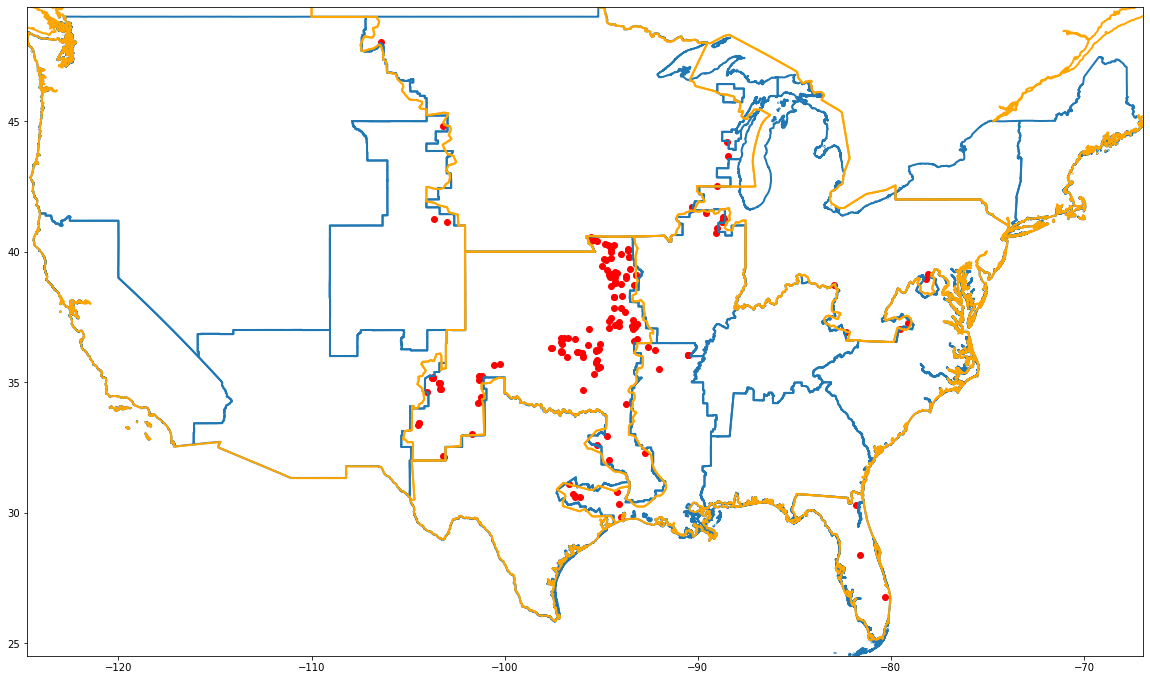

In [81]:
fig, ax = plt.subplots(figsize = (20,16)) 
egrid_cleaned[mask].plot(color='r', ax=ax)
hilfd.boundary.plot(linewidth = 2,ax=ax) 
ecoinvent.boundary.plot(edgecolor='orange', linewidth = 2,ax=ax) 

def set_bounds_by_layer(lyr, ax):
    xlim = ([lyr.total_bounds[0],  lyr.total_bounds[2]])
    ylim = ([lyr.total_bounds[1],  lyr.total_bounds[3]])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)    

set_bounds_by_layer(hilfd, ax)

Aside from a few randoms (is Florida man still a meme?), we see SPP (as we should), and a few other plants that are close to other NERC region borders.

We can also look at statistics on where the four data sources disagree.

In [82]:
with pd.option_context('display.max_rows', 100):
    display(egrid.groupby(['NERC_egrid', 'NERC_ecoinvent', 'NERC_eia', 'NERC_hilfd']).agg(['count'])['Plant name'])

count
NERC_egrid NERC_ecoinvent NERC_eia NERC_hilfd       
FRCC       FRCC           SERC     FRCC          206
                                   SERC            1
           SERC           SERC     SERC            2
MRO        MRO            -        MRO            15
                          MRO      MRO          1140
                                   RFC            17
                          RFC      MRO            24
                                   RFC             3
                          SERC     MRO             4
                          SPP      MRO             1
                          WECC     MRO             8
           RFC            MRO      MRO            11
                          RFC      MRO             3
                                   RFC             4
           SERC           -        MRO             1
                                   SERC            6
                          RFC      SERC            1
                          SERC     MRO             3
                                   SERC            5
           SPP            -        SERC            1
                                   SPP            54
                          SERC     SPP            19
                          SPP      SPP           333
                          TRE      SPP             3
                                   TRE             1
                          WECC     SPP             9
           TRE            TRE      TRE             1
           WECC           MRO      MRO             2
                                   WECC            3
                          WECC     WECC            2
NPCC       NPCC           NPCC     NPCC         1465
                                   RFC             2
           RFC            RFC      RFC            19
RFC        FRCC           SERC     FRCC            1
           MRO            MRO      MRO            10
                                   RFC            11
                          RFC      MRO             3
                                   RFC            17
                          SERC     MRO             2
           NPCC           NPCC     NPCC           10
           RFC            MRO      MRO            11
                                   RFC            11
                          RFC      MRO             1
                                   RFC          1474
                                   SERC            2
                          SERC     RFC             8
                                   SERC            2
           SERC           RFC      RFC            24
                                   SERC           11
                          SERC     RFC             3
                                   SERC           29
           WECC           WECC     WECC            1
SERC       FRCC           SERC     FRCC            2
                                   SERC            1
           RFC            RFC      RFC             6
                                   SERC            1
                          SERC     RFC             3
                                   SERC            2
           SERC           -        MRO             1
                                   SERC           11
                          RFC      SERC            9
                          SERC     MRO             2
                                   RFC             7
                                   SERC         1941
                                   SPP             1
                          SPP      SERC            1
                          TRE      SERC           24
           SPP            -        SERC            1
                                   SPP            20
                          SERC     SERC            1
                                   SPP             9
                          SPP      SPP            16
           TRE            TRE      SERC            1
TRE        SERC           TRE      SERC            8
                   